# **Train a model using Tab Transformer for Weather Prediction**

Import Libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import resample, class_weight
import joblib

Load the dataset

In [19]:
DATA_PATH = "weatherAUS_updated.csv"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

**Basic Cleaning**

The dataset contains missing values and inconsistent data types. We’ll:

* Convert the Date column to datetime format.

* Map the target column RainTomorrow from "Yes"/"No" to binary 1/0.

* Drop rows with missing target values.

In [20]:
print("Loading data...")
df = pd.read_csv(DATA_PATH)

print("Basic cleaning...")
df['Date'] = pd.to_datetime(df['Date'])
df = df[~df['RainTomorrow'].isna()].copy()

# Map target variable
#df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})


Loading data...
Basic cleaning...


**Feature Engineering**

In this step, we’ll create additional useful features:

* Extract Month and DayOfWeek from Date.

* Add a simple Season feature based on the month.

* Fill missing numeric features with median values and categorical features with "Missing".

This step helps models capture temporal and categorical patterns.

In [21]:
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Season'] = ((df['Month'] % 12 + 3)//3)

# Fill missing numeric with median
numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['RainTomorrow']]
for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

# Fill categorical missing with "Missing"
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna('Missing')

# ---- Outlier Removal (IQR) ----
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
print(f"✅ After IQR outlier removal: {df.shape[0]} rows remain")

# ---- Correlation Filtering ----
corr_matrix = df[numeric_cols].corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
df = df.drop(columns=drop_cols, errors='ignore')
if drop_cols:
    print(f"⚠️ Dropped highly correlated columns (>|0.9|): {drop_cols}")
else:
    print("✅ No highly correlated columns found")

🧠 Feature engineering...
✅ After IQR outlier removal: 37833 rows remain
⚠️ Dropped highly correlated columns (>|0.9|): ['Pressure3pm', 'Temp3pm']


**Feature Selection**

We’ll choose a subset of relevant numeric and categorical features from the dataset.

* Numeric Features: Temperature, humidity, pressure, wind speed, etc.

* Categorical Features: Location, wind direction, season, month, and day of week.

This helps reduce model complexity and training time

In [22]:
numeric_features = [
    'MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine',
    'WindGustSpeed','WindSpeed9am','WindSpeed3pm',
    'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm',
    'Temp9am','Temp3pm'
]
numeric_features = [c for c in numeric_features if c in df.columns]

categorical_features = ['Location','WindGustDir','WindDir9am','WindDir3pm','Season','Month','DayOfWeek']
categorical_features = [c for c in categorical_features if c in df.columns]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Temp9am']
Categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Season', 'Month', 'DayOfWeek']


In [23]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['RainTomorrow'], random_state=RANDOM_SEED)

In [24]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
label_encoders = {}

# Fit on train
scaler.fit(train_df[numeric_features])
ohe.fit(train_df[categorical_features].astype(str))

for c in categorical_features:
    le = LabelEncoder()
    le.fit(train_df[c].astype(str))
    label_encoders[c] = le

# Transform
X_train_num = scaler.transform(train_df[numeric_features])
X_test_num = scaler.transform(test_df[numeric_features])

y_train = train_df['RainTomorrow'].values
y_test = test_df['RainTomorrow'].values

for c in categorical_features:
    le = LabelEncoder()
    le.fit(df[c].astype(str))  # full df ensures unseen labels are included
    label_encoders[c] = le


# Label encode categorical features
def label_encode(df):
    encoded = []
    for c in categorical_features:
        le = label_encoders[c]
        encoded.append(le.transform(df[c].astype(str)))
    return encoded

X_train_cats = label_encode(train_df)
X_test_cats = label_encode(test_df)

In [25]:
def build_tabtransformer(numerical_dim, categorical_cardinalities, embedding_dim=8, num_heads=4, ff_dim=32, n_transformer_blocks=2, dense_units=[64], dropout_rate=0.2):
    cat_inputs = []
    embed_layers = []
    for i, card in enumerate(categorical_cardinalities):
        inp = keras.Input(shape=(1,), dtype='int32', name=f'cat_inp_{i}')
        emb = layers.Embedding(input_dim=card, output_dim=embedding_dim, name=f'emb_{i}')(inp)
        emb = layers.Reshape((embedding_dim,))(emb)
        cat_inputs.append(inp)
        embed_layers.append(emb)

    if len(embed_layers) > 1:
        cat_stack = layers.Concatenate(axis=1)([layers.Reshape((1, embedding_dim))(e) for e in embed_layers])
        num_cats = len(embed_layers)
        cat_stack = layers.Reshape((num_cats, embedding_dim))(cat_stack)
    else:
        cat_stack = layers.Reshape((1, embedding_dim))(embed_layers[0])

    x = cat_stack
    for _ in range(n_transformer_blocks):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        attn_output = layers.Add()([x, attn_output])
        attn_output = layers.LayerNormalization()(attn_output)

        ff = layers.Dense(ff_dim, activation='relu')(attn_output)
        ff = layers.Dense(embedding_dim)(ff)
        x = layers.Add()([attn_output, ff])
        x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)

    num_input = keras.Input(shape=(numerical_dim,), name='num_input')
    num_x = layers.Dense(64, activation='relu')(num_input)
    num_x = layers.Dropout(dropout_rate)(num_x)

    combined = layers.Concatenate()([x, num_x])
    for u in dense_units:
        combined = layers.Dense(u, activation='relu')(combined)
        combined = layers.Dropout(dropout_rate)(combined)
    out = layers.Dense(1, activation='sigmoid')(combined)

    inputs = [*cat_inputs, num_input]
    model = keras.Model(inputs=inputs, outputs=out, name='TabTransformer_like')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc')])
    return model

cardinalities = [len(label_encoders[c].classes_) for c in categorical_features]
tabmodel = build_tabtransformer(len(numeric_features), cardinalities, embedding_dim=8, num_heads=2, ff_dim=32, n_transformer_blocks=2, dense_units=[128,64])

tabmodel.summary()


Model: "TabTransformer_like"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat_inp_0           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_inp_1           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_inp_2           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_inp_3           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_inp_4           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_inp_5           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_inp_6           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_0 (Embedding)   │ (None, 1, 8)      │        352 │ cat_inp_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_1 (Embedding)   │ (None, 1, 8)      │        136 │ cat_inp_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_2 (Embedding)   │ (None, 1, 8)      │        136 │ cat_inp_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_3 (Embedding)   │ (None, 1, 8)      │        136 │ cat_inp_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_4 (Embedding)   │ (None, 1, 8)      │         32 │ cat_inp_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_5 (Embedding)   │ (None, 1, 8)      │         96 │ cat_inp_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_6 (Embedding)   │ (None, 1, 8)      │         56 │ cat_inp_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8)         │          0 │ emb_0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8)         │          0 │ emb_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8)         │          0 │ emb_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 8)         │          0 │ emb_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 8)         │          0 │ emb_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 8)         │          0 │ emb_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 8)         │          0 │ emb_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,745 (84.94 KB)

 Trainable params: 21,745 (84.94 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
def prepare_inputs(df):
    num = scaler.transform(df[numeric_features].values)
    cats = [label_encoders[c].transform(df[c].astype(str)).reshape(-1,1) for c in categorical_features]
    inputs = {f'cat_inp_{i}': cats[i] for i in range(len(categorical_features))}
    inputs['num_input'] = num
    return inputs

X_train_tab = prepare_inputs(train_df)
X_test_tab = prepare_inputs(test_df)

history = tabmodel.fit(
    X_train_tab,
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=256,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)]
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7035 - auc: 0.7161 - loss: 0.5746 - val_accuracy: 0.7767 - val_auc: 0.8289 - val_loss: 0.4749
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7641 - auc: 0.8179 - loss: 0.4904 - val_accuracy: 0.7872 - val_auc: 0.8470 - val_loss: 0.4527
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7770 - auc: 0.8369 - loss: 0.4691 - val_accuracy: 0.7915 - val_auc: 0.8588 - val_loss: 0.4374
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7835 - auc: 0.8472 - loss: 0.4563 - val_accuracy: 0.8001 - val_auc: 0.8659 - val_loss: 0.4282
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7875 - auc: 0.8538 - loss: 0.4474 - val_accuracy: 0.8028 - val_auc: 0.8720 - val_loss: 0.4190
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7940 - auc: 0.8608 - loss: 0.4380 - val_accuracy: 0.8081 - val_auc: 0.8778 - val_loss: 0.4114
Epoch 7/50
107/107 ━━━━━━━━━━━━━━

237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Train Accuracy: 0.8598, Validation Accuracy: 0.8474
Test Accuracy: 0.8382, Precision: 0.7602, Recall: 0.7937, F1: 0.7766, AUC: 0.9170
              precision    recall  f1-score   support

         0.0     0.8840    0.8627    0.8732      4887
         1.0     0.7602    0.7937    0.7766      2680

    accuracy                         0.8382      7567
   macro avg     0.8221    0.8282    0.8249      7567
weighted avg     0.8402    0.8382    0.8390      7567



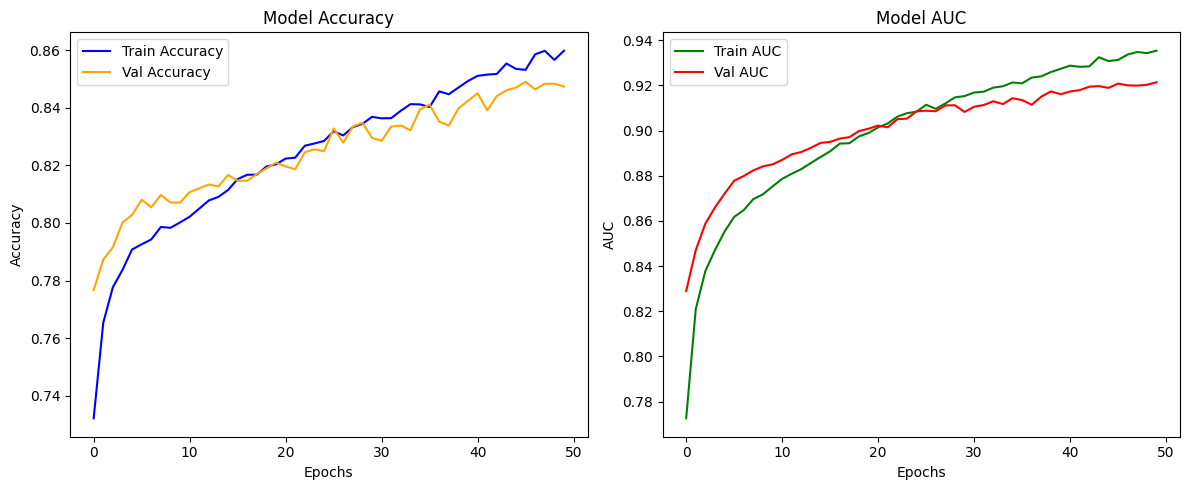

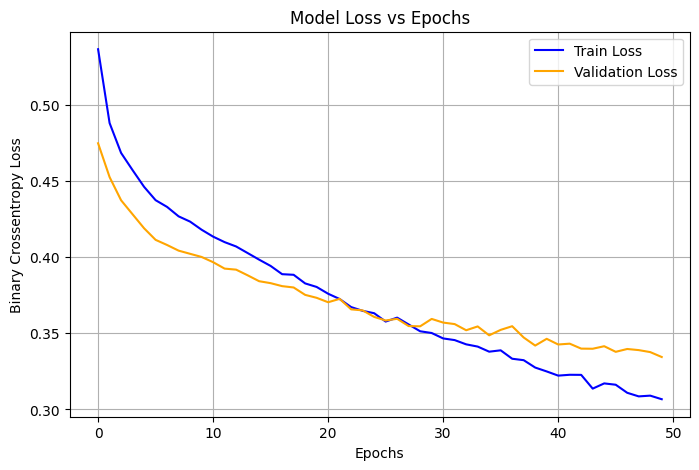

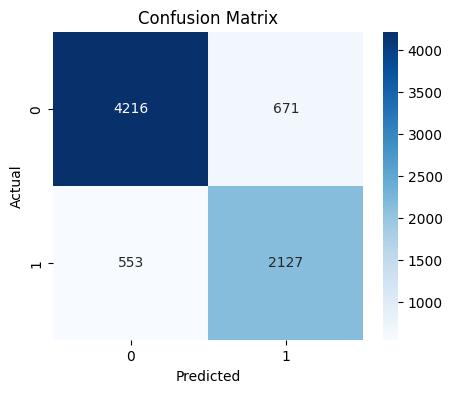

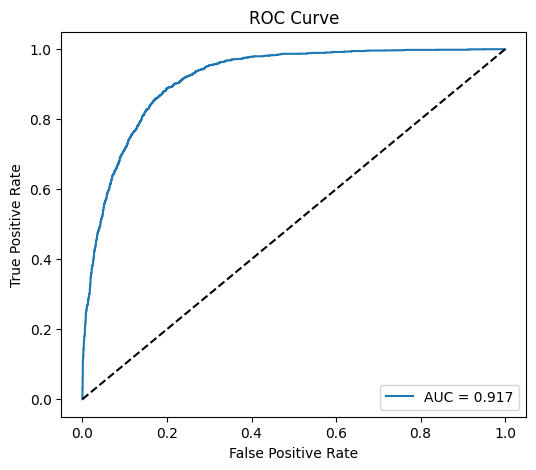

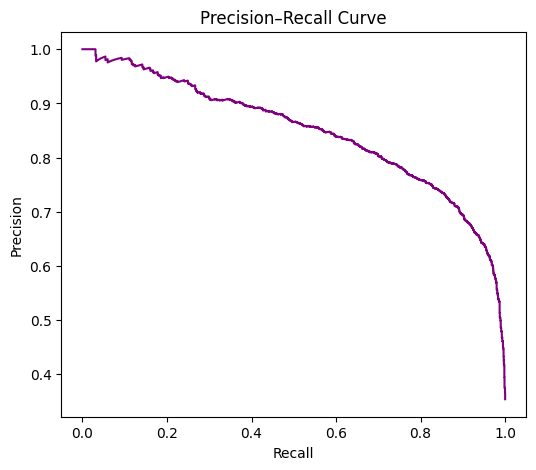

In [29]:
# ---- Predictions on test set ----
preds_proba = tabmodel.predict(X_test_tab).ravel()
preds = (preds_proba >= 0.5).astype(int)

# ---- Metrics ----
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc = roc_auc_score(y_test, preds_proba)

print(f"Train Accuracy: {history.history['accuracy'][-1]:.4f}, Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
print(classification_report(y_test, preds, digits=4))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

# ---- 1. Training Curves (Accuracy & AUC)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='Train AUC', color='green')
plt.plot(history.history['val_auc'], label='Val AUC', color='red')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Loss vs Epochs ----
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Model Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---- 2. Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---- 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, preds_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

# ---- 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, preds_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple')
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()